In [1]:
# import important modules
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# text preprocessing modules
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (

    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from string import punctuation
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
# text preprocessing modules
from nltk.tokenize import word_tokenize
from cleantext import clean
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

In [2]:
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
    "stopwords"
):
    nltk.download(dependency)

[nltk_data] Downloading package brown to C:\Users\nanji/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to C:\Users\nanji/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\nanji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nanji/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\nanji/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nanji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [4]:
# Fonction de nettoyage
def clean_text(text):
    # 1. Minuscule
    text = text.lower()
    # 3. Supprimer les URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " link ", text)
    # 4. Supprimer les nombres
    text = re.sub(r"\b\d+\b", "", text)
    # 5. Supprimer la ponctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # 6. Tokenisation + stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # 7. Lemmatisation
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [5]:
df = pd.read_csv('./data/Augmented_App_Reviews_Dataset.csv')
df['label'].unique()

array(['Premium Features', 'User Feedbacks & Recommendations',
       'General Topics', 'Ads', 'Crashes and Bugs', 'Updates',
       'Customer Support'], dtype=object)

In [6]:
df["clean_review"] = df["review"].apply(clean_text)

In [7]:
df

,date,platform,country,review,star,user_id,issue_flag,likes_count,dislike_count,label,clean_review
0,07/07/2023,iOS,Australia,Love the itinerary sharing feature. It makes p...,5,13c95471-be12-42f6-95d1-fa3dd104909b,No,1,1,Premium Features,love itinerary sharing feature make planning g...
1,12/08/2023,Android,India,"The premium price is a bit high, but the featu...",4,945725ef-7277-4884-b717-9259af1df8d2,No,2,2,Premium Features,premium price bit high feature okay
2,12/09/2023,iOS,UK,I can't share my trip details via WhatsApp dir...,5,e3d956b8-6e00-4099-84ca-f51406e6b3f7,No,5,3,User Feedbacks & Recommendations,cant share trip detail via whatsapp directly w...
3,12/07/2023,Android,Brazil,"The price of premium is too high, could be bet...",3,1fa559f7-a707-4f23-97f9-1cb92a0ba85b,No,0,0,Premium Features,price premium high could better
4,24/09/2023,iOS,India,Smooth booking experience.,3,67934645-a9bf-4283-b809-1baa3f067b19,No,2,5,General Topics,smooth booking experience
...,...,...,...,...,...,...,...,...,...,...,...
15310,13/10/2024,Android,Dominican Republic,Support never replies to emails.,1,93898eaf-3c4d-4456-9709-a84c9d67eec1,Yes,1,4,Customer Support,support never reply email
15311,31/10/2024,iOS,Slovenia,Support didn’t resolve my issue.,4,16f20d13-d4f1-48e0-a0a9-4cc2f0b79b3b,Yes,2,1,Customer Support,support didn’t resolve issue
15312,12/07/2023,Android,Hungary,Support never replies to emails.,4,39fa9c25-7b17-4af2-b7c9-d8fcd9a3959d,Yes,6,2,Customer Support,support never reply email
15313,11/12/2023,iOS,Croatia,Still waiting for a response from support.,2,71d43692-2f2f-498e-850b-0333eb6ffa20,Yes,10,3,Customer Support,still waiting response support


In [8]:
# Initialiser le vectorizer
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)

# Appliquer la transformation sur les textes nettoyés
X = vectorizer.fit_transform(df["clean_review"])


# Les étiquettes à prédire (catégories)
y = df["label"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=52, stratify=y)

In [10]:
# Entraîner le modèle
clf = MultinomialNB()
clf.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [11]:
y_pred = clf.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred))

                                  precision    recall  f1-score   support

                             Ads       1.00      0.99      1.00       544
                Crashes and Bugs       0.99      0.98      0.99       557
                Customer Support       1.00      1.00      1.00       536
                  General Topics       0.98      0.98      0.98       556
                Premium Features       0.99      1.00      1.00       545
                         Updates       0.99      1.00      0.99       546
User Feedbacks & Recommendations       0.99      0.99      0.99       545

                        accuracy                           0.99      3829
                       macro avg       0.99      0.99      0.99      3829
                    weighted avg       0.99      0.99      0.99      3829



In [13]:
# Sauvegarde du modèle
joblib.dump(clf, "./model/model_bug_classifier.pkl")

# Sauvegarde du vectorizer
joblib.dump(vectorizer, "./model/vectorizer_bug_classifier.pkl")

['./model/vectorizer_bug_classifier.pkl']

In [14]:
# Obtenir les classes et les mots
classes = clf.classes_
feature_names = vectorizer.get_feature_names_out()

# Parcourir les classes
for i, class_label in enumerate(classes):
    print(f"\n🔍 Mots les plus caractéristiques de la classe : {class_label}")

    # Top indices des mots les plus probables pour cette classe
    top_indices = np.argsort(clf.feature_log_prob_[i])[-10:]  # top 10

    top_words = feature_names[top_indices]
    top_scores = clf.feature_log_prob_[i][top_indices]

    for word, score in zip(top_words[::-1], top_scores[::-1]):
        print(f"{word:<20} → log-proba : {score:.4f}")


🔍 Mots les plus caractéristiques de la classe : Ads
ad                   → log-proba : -1.4786
even                 → log-proba : -2.9950
premium              → log-proba : -2.9950
get                  → log-proba : -2.9978
buying               → log-proba : -2.9978
forever              → log-proba : -3.0765
load                 → log-proba : -3.0765
take                 → log-proba : -3.0765
banner               → log-proba : -3.1041
reduce               → log-proba : -3.1041

🔍 Mots les plus caractéristiques de la classe : Crashes and Bugs
crash                → log-proba : -2.3296
startup              → log-proba : -2.9635
switching            → log-proba : -2.9862
glitch               → log-proba : -2.9891
account              → log-proba : -2.9891
app                  → log-proba : -3.0546
keep                 → log-proba : -3.0701
freezing             → log-proba : -3.0954
time                 → log-proba : -3.1018
android              → log-proba : -3.1051

🔍 Mots les plus cara

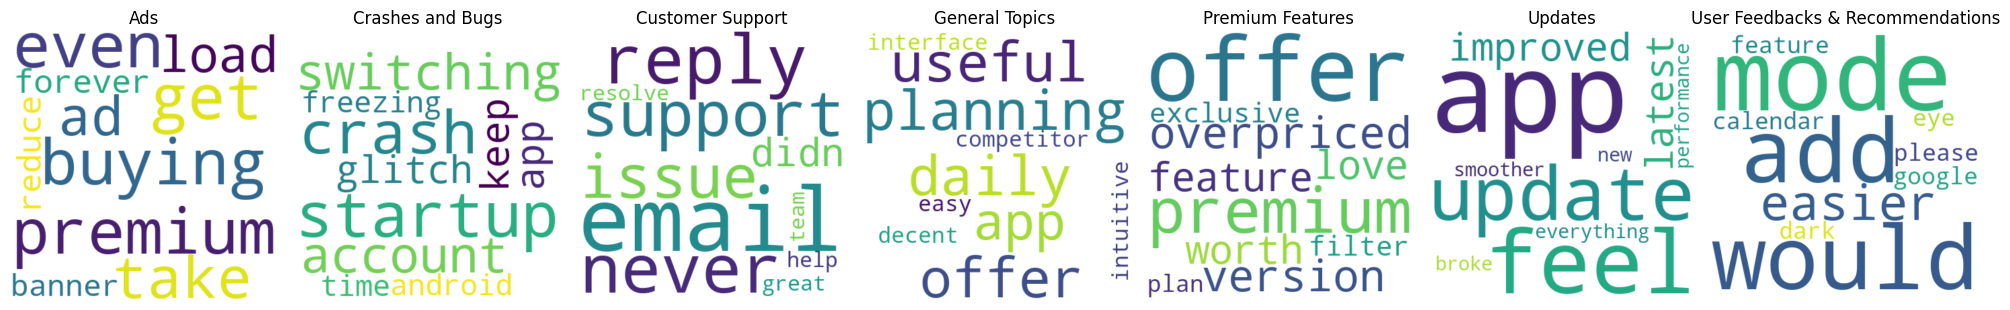

In [15]:
classes = clf.classes_
feature_names = vectorizer.get_feature_names_out()

# Créer une ligne de WordClouds
plt.figure(figsize=(20, 5))

for i, class_label in enumerate(classes):
    # Récupérer les top 10 indices de mots pour cette classe
    top_indices = np.argsort(clf.feature_log_prob_[i])[-10:]
    top_words = feature_names[top_indices]
    top_scores = clf.feature_log_prob_[i][top_indices]

    # Préparer les données pour WordCloud
    word_freq = {word: score for word, score in zip(top_words, top_scores)}

    # Générer le WordCloud
    wc = WordCloud(width=400, height=400, background_color='white')
    wc.generate_from_frequencies(word_freq)

    # Affichage
    plt.subplot(1, len(classes), i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(class_label, fontsize=12)

plt.tight_layout()
plt.show()

In [16]:
# 20 exemples de texte à tester (à modifier selon ton besoin)
custom_reviews = [
    "The app crashes every time I open the settings.",
    "I wish there were more options in the free version.",
    "The new update is amazing!",
    "Too many ads, it's really annoying.",
    "I contacted support but they never replied.",
    "Smoot user experience and great design!",
    "Can you please add support for dark mode?",
    "Still waitin for the latest bug fix...",
    "Love the premium itinerary feature!",
    "Crashes on Android 14 when importing files.",
    "The customer service was very helpful.",
    "I lost my data after the last update!",
    "Where can I cancel my premium subscription?",
    "The ads pop up too often.",
    "Booking was quick and easy, thanks!",
    "The UI is confusing on iOS.",
    "I like the reminders, very helpful!",
    "My payment didn’t go through but I was charged.",
    "Everything is great except the speed.",
    "App keeps freezing after login.",
]

# Nettoyage
cleaned = [clean_text(text) for text in custom_reviews]

# Vectorisation
X_custom = vectorizer.transform(cleaned)

# Prédiction
preds = clf.predict(X_custom)

# Affichage
for review, pred in zip(custom_reviews, preds):
    print(f"📝 Avis : {review}\n➡️  Catégorie prédite : {pred}\n")

📝 Avis : The app crashes every time I open the settings.
➡️  Catégorie prédite : Crashes and Bugs

📝 Avis : I wish there were more options in the free version.
➡️  Catégorie prédite : Premium Features

📝 Avis : The new update is amazing!
➡️  Catégorie prédite : Updates

📝 Avis : Too many ads, it's really annoying.
➡️  Catégorie prédite : Ads

📝 Avis : I contacted support but they never replied.
➡️  Catégorie prédite : Customer Support

📝 Avis : Smoot user experience and great design!
➡️  Catégorie prédite : Premium Features

📝 Avis : Can you please add support for dark mode?
➡️  Catégorie prédite : User Feedbacks & Recommendations

📝 Avis : Still waitin for the latest bug fix...
➡️  Catégorie prédite : Crashes and Bugs

📝 Avis : Love the premium itinerary feature!
➡️  Catégorie prédite : Premium Features

📝 Avis : Crashes on Android 14 when importing files.
➡️  Catégorie prédite : Crashes and Bugs

📝 Avis : The customer service was very helpful.
➡️  Catégorie prédite : Customer Support

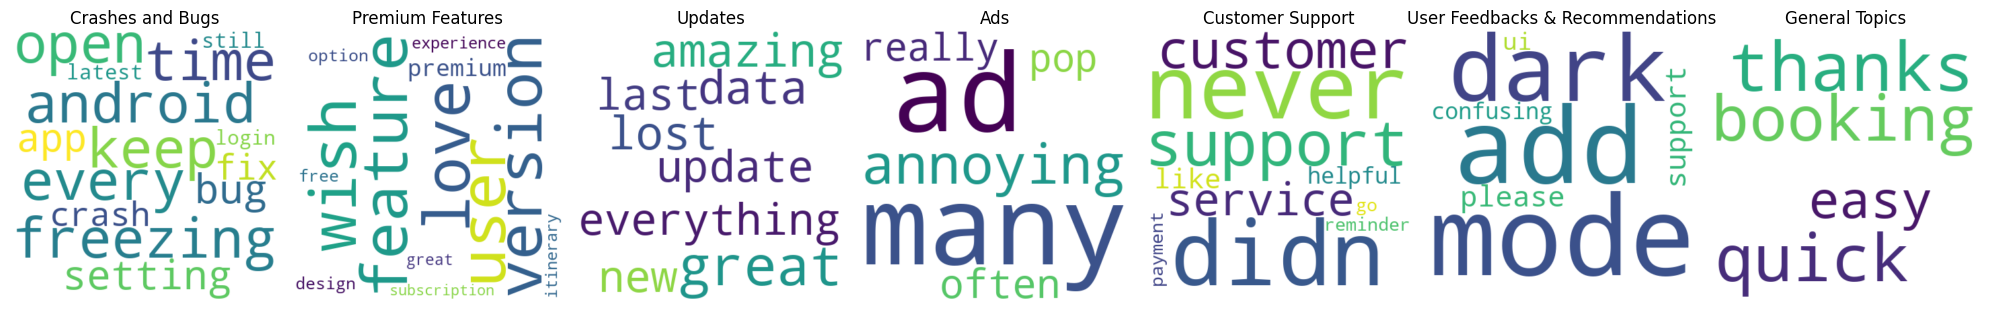

In [17]:
# Étape 1 : Nettoyage
cleaned = [clean_text(text) for text in custom_reviews]

# Étape 2 : Vectorisation
X_custom = vectorizer.transform(cleaned)

# Étape 3 : Prédiction
preds = clf.predict(X_custom)

# Étape 4 : Accumuler les poids des mots par prédiction de classe
classes = clf.classes_
feature_names = vectorizer.get_feature_names_out()
log_probs = clf.feature_log_prob_

# Dictionnaire {classe: {mot: somme(log-proba)}}
class_word_scores = defaultdict(lambda: defaultdict(float))

for i, row in enumerate(X_custom):
    pred_class = preds[i]
    class_index = list(classes).index(pred_class)

    # Convertir ligne en (index mot, fréquence)
    for idx in row.nonzero()[1]:
        word = feature_names[idx]
        score = log_probs[class_index][idx]
        class_word_scores[pred_class][word] += score

# Étape 5 : Afficher les WordClouds
plt.figure(figsize=(20, 5))
for i, (label, word_scores) in enumerate(class_word_scores.items()):
    wc = WordCloud(width=400, height=400, background_color='white')
    wc.generate_from_frequencies(word_scores)

    plt.subplot(1, len(class_word_scores), i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(label, fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
from gensim.models import Word2Vec

# Tokenisation pour Word2Vec
df["tokens"] = df["clean_review"].apply(lambda x: x.split())

# Entraîner le modèle Word2Vec
w2v_model = Word2Vec(
    sentences=df["tokens"], vector_size=100, window=5, min_count=2, workers=4, seed=123)

# Fonction pour obtenir la moyenne des vecteurs Word2Vec pour chaque review


def get_w2v_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)


# Appliquer à tout le dataset
X_w2v = np.vstack(df["tokens"].apply(
    lambda x: get_w2v_vector(x, w2v_model, 100)))

# Les étiquettes à prédire (catégories)
y = df["label"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_w2v, y, test_size=0.25, random_state=52, stratify=y
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_w2v = RandomForestClassifier(random_state=123)
clf_w2v.fit(X_train, y_train)
y_pred = clf_w2v.predict(X_test)
print(classification_report(y_test, y_pred))

                                  precision    recall  f1-score   support

                             Ads       1.00      1.00      1.00       544
                Crashes and Bugs       0.98      0.99      0.98       557
                Customer Support       1.00      1.00      1.00       536
                  General Topics       0.99      0.99      0.99       556
                Premium Features       1.00      1.00      1.00       545
                         Updates       0.99      1.00      0.99       546
User Feedbacks & Recommendations       0.99      0.99      0.99       545

                        accuracy                           0.99      3829
                       macro avg       0.99      0.99      0.99      3829
                    weighted avg       0.99      0.99      0.99      3829



In [ ]:
# Sauvegarde du modèle RandomForest entraîné sur Word2Vec
joblib.dump(clf_w2v, "./model/model_word2vec_classifier.pkl")

# Sauvegarde du modèle Word2Vec lui-même (format natif gensim)
w2v_model.save("./model/word2vec_gensim.model")

In [ ]:
# 20 exemples de texte à tester (Word2Vec + RandomForest)
custom_reviews = [
    "The app crashes every time I open the settings.",
    "I wish there were more options in the free version.",
    "The new update is amazing!",
    "Too many ads, it's really annoying.",
    "I contacted support but they never replied.",
    "Smoot user experience and great design!",
    "Can you please add support for dark mode?",
    "Still waitin for the latest bug fix...",
    "Love the premium itinerary feature!",
    "Crashes on Android 14 when importing files.",
    "The customer service was very helpful.",
    "I lost my data after the last update!",
    "Where can I cancel my premium subscription?",
    "The ads pop up too often.",
    "Booking was quick and easy, thanks!",
    "The UI is confusing on iOS.",
    "I like the reminders, very helpful!",
    "My payment didn’t go through but I was charged.",
    "Everything is great except the speed.",
    "App keeps freezing after login.",
]

# Nettoyage
cleaned = [clean_text(text) for text in custom_reviews]

# Tokenisation
tokens = [text.split() for text in cleaned]

# Vectorisation avec Word2Vec (moyenne des vecteurs)
def get_w2v_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

X_custom_w2v = np.vstack([get_w2v_vector(tok, w2v_model, 100) for tok in tokens])

# Prédiction avec le classifieur entraîné sur Word2Vec
preds = clf_w2v.predict(X_custom_w2v)

# Affichage
for review, pred in zip(custom_reviews, preds):
    print(f"📝 Avis : {review}\n➡️  Catégorie prédite : {pred}\n")

📝 Avis : The app crashes every time I open the settings.
➡️  Catégorie prédite : Crashes and Bugs

📝 Avis : I wish there were more options in the free version.
➡️  Catégorie prédite : Premium Features

📝 Avis : The new update is amazing!
➡️  Catégorie prédite : Updates

📝 Avis : Too many ads, it's really annoying.
➡️  Catégorie prédite : Ads

📝 Avis : I contacted support but they never replied.
➡️  Catégorie prédite : Customer Support

📝 Avis : Smoot user experience and great design!
➡️  Catégorie prédite : User Feedbacks & Recommendations

📝 Avis : Can you please add support for dark mode?
➡️  Catégorie prédite : User Feedbacks & Recommendations

📝 Avis : Still waitin for the latest bug fix...
➡️  Catégorie prédite : Crashes and Bugs

📝 Avis : Love the premium itinerary feature!
➡️  Catégorie prédite : Premium Features

📝 Avis : Crashes on Android 14 when importing files.
➡️  Catégorie prédite : Crashes and Bugs

📝 Avis : The customer service was very helpful.
➡️  Catégorie prédite : 

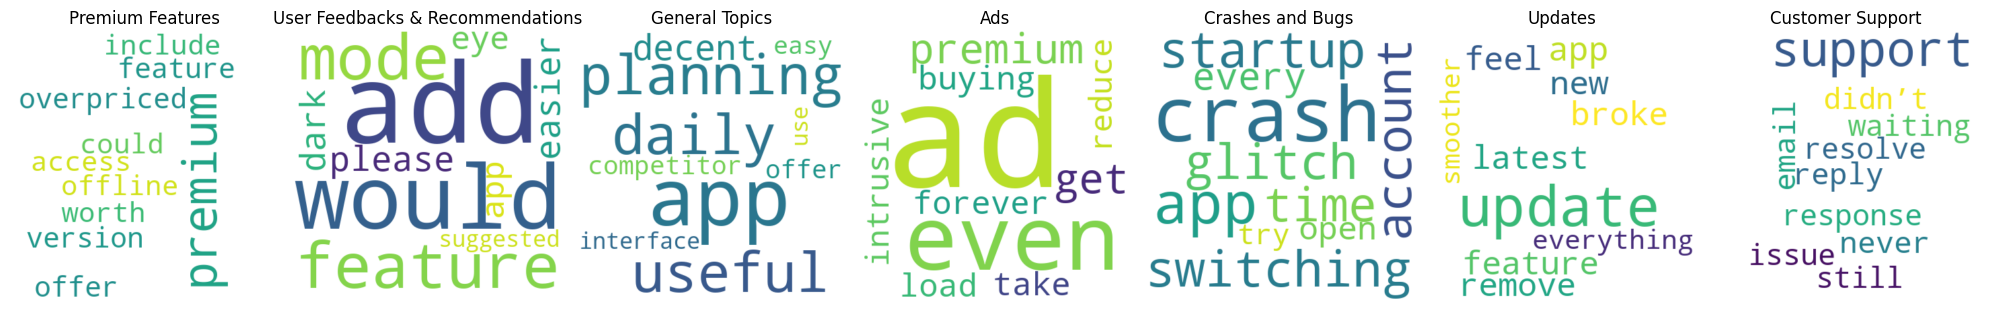

In [13]:
from collections import Counter

plt.figure(figsize=(20, 5))
classes = df['label'].unique()

for i, class_label in enumerate(classes):
    # Sélectionner les tokens de la classe
    tokens = df[df['label'] == class_label]['tokens'].sum()
    # Compter les mots les plus fréquents
    most_common = Counter(tokens).most_common(10)
    word_freq = dict(most_common)

    wc = WordCloud(width=400, height=400, background_color='white')
    wc.generate_from_frequencies(word_freq)

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(class_label, fontsize=12)

plt.tight_layout()
plt.show()